In [1]:
# Import Python libraries
import vertexai
from vertexai.generative_models import GenerativeModel, Part
from google.cloud import bigquery
from google.cloud import storage
import json
import io
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from IPython.display import Audio
from pprint import pprint

In [2]:
# Set Python variables for project_id and region
project_id = "qwiklabs-gcp-01-e00320b4bc7b"
region = " us-central1"

In [3]:
# Create the resource connection
!bq mk --connection \
  --connection_type=CLOUD_RESOURCE \
  --location=US \
  gemini_conn

Connection 417110499489.us.gemini_conn successfully created


In [4]:
# Create the dataset
%%bigquery
CREATE SCHEMA IF NOT EXISTS `qwiklabs-gcp-01-e00320b4bc7b.gemini_demo`
OPTIONS(location="US");

Query is running:   0%|          |

""


In [5]:
# Create the customer reviews table
%%bigquery
LOAD DATA OVERWRITE gemini_demo.customer_reviews
(customer_review_id INT64, customer_id INT64, location_id INT64, review_datetime DATETIME, review_text STRING, social_media_source STRING, social_media_handle STRING)
FROM FILES (
  format = 'CSV',
  uris = ['gs://qwiklabs-gcp-01-e00320b4bc7b-bucket/gsp1249/customer_reviews.csv']);

Query is running:   0%|          |

""


In [6]:
# Create the customer reviews table
%%bigquery
SELECT * FROM `gemini_demo.customer_reviews`
ORDER BY review_datetime

Query is running:   0%|          |

Downloading:   0%|          |

,customer_review_id,customer_id,location_id,review_datetime,review_text,social_media_source,social_media_handle
0,5499,3383,1,2024-01-01 22:36:10,"Good service, short wait time for quality coff...",Twitter,mrs_m_888
1,1711,9574,1,2024-01-07 19:58:10,"Great atmosphere, and drinks are always on po...",Twitter,coffee_lover_98
2,2339,5640,1,2024-01-10 00:05:10,The wait time was short so I got excellent ser...,Twitter,coffeeholic7
3,4316,3309,1,2024-01-13 12:22:10,The staff was very friendly and the coffee was...,Facebook,@joesmith
4,995,8206,1,2024-01-16 20:00:10,The service could be improved. I think it’s di...,Google,coffee_drinker_39
5,6818,4557,1,2024-01-24 04:24:10,I had a great experience at this coffee truck....,Instagram,coffee_lover_123
6,7835,5511,1,2024-01-28 23:27:10,The customer service was great and the wait ti...,Facebook,johndoe123
7,5484,8452,1,2024-02-05 15:41:10,I had a great experience at this coffee truck....,Facebook,joesmith123
8,5006,3174,1,2024-02-05 18:02:10,Good location and delicious coffee,Facebook,joe.doe@gmail.com
9,5487,2909,1,2024-02-06 10:23:10,Bad Service. The staff was rude and unhelpful...,Twitter,not_real_user


In [9]:
# Create the customer reviews table
%%bigquery
CREATE OR REPLACE MODEL `gemini_demo.gemini_pro`
REMOTE WITH CONNECTION `us.gemini_conn`
OPTIONS (endpoint = 'gemini-pro')

Query is running:   0%|          |

""


In [10]:
# Create the sentiment analysis table
%%bigquery
CREATE OR REPLACE TABLE
`gemini_demo.customer_reviews_analysis` AS (
SELECT ml_generate_text_llm_result, social_media_source, review_text, customer_id, location_id, review_datetime
FROM
ML.GENERATE_TEXT(
MODEL `gemini_demo.gemini_pro`,
(
   SELECT social_media_source, customer_id, location_id, review_text, review_datetime, CONCAT(
      'Classify the sentiment of the following text as positive or negative.',
      review_text, "In your response don't include the sentiment explanation. Remove all extraneous information from your response, it should be a boolean response either positive or negative.") AS prompt
   FROM `gemini_demo.customer_reviews`
),
STRUCT(
   0.2 AS temperature, TRUE AS flatten_json_output)));

Query is running:   0%|          |

""


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

In [11]:
# Pull the first 100 records from the customer_reviews_analysis table
%%bigquery
SELECT * FROM `gemini_demo.customer_reviews_analysis`
ORDER BY review_datetime

Query is running:   0%|          |

Downloading:   0%|          |

,ml_generate_text_llm_result,social_media_source,review_text,customer_id,location_id,review_datetime
0,positive,Twitter,"Good service, short wait time for quality coff...",3383,1,2024-01-01 22:36:10
1,positive,Twitter,"Great atmosphere, and drinks are always on po...",9574,1,2024-01-07 19:58:10
2,positive,Twitter,The wait time was short so I got excellent ser...,5640,1,2024-01-10 00:05:10
3,positive,Facebook,The staff was very friendly and the coffee was...,3309,1,2024-01-13 12:22:10
4,negative,Google,The service could be improved. I think it’s di...,8206,1,2024-01-16 20:00:10
5,positive,Instagram,I had a great experience at this coffee truck....,4557,1,2024-01-24 04:24:10
6,positive,Facebook,The customer service was great and the wait ti...,5511,1,2024-01-28 23:27:10
7,positive,Facebook,I had a great experience at this coffee truck....,8452,1,2024-02-05 15:41:10
8,positive,Facebook,Good location and delicious coffee,3174,1,2024-02-05 18:02:10
9,negative,Twitter,Bad Service. The staff was rude and unhelpful...,2909,1,2024-02-06 10:23:10


In [12]:
# Sanitize the records within a new view
%%bigquery
CREATE OR REPLACE VIEW gemini_demo.cleaned_data_view AS
SELECT REPLACE(REPLACE(LOWER(ml_generate_text_llm_result), '.', ''), ' ', '') AS sentiment,
REGEXP_REPLACE(
      REGEXP_REPLACE(
            REGEXP_REPLACE(social_media_source, r'Google(\+|\sReviews|\sLocal|\sMy\sBusiness|\sreviews|\sMaps)?', 'Google'),
            'YELP', 'Yelp'
      ),
      r'SocialMedia1?', 'Social Media'
   ) AS social_media_source,
review_text, customer_id, location_id, review_datetime
FROM `gemini_demo.customer_reviews_analysis`;

Query is running:   0%|          |

""


In [13]:
# Pull the first 100 records from the cleaned_data_view view
%%bigquery
SELECT * FROM `gemini_demo.cleaned_data_view`
ORDER BY review_datetime

Query is running:   0%|          |

Downloading:   0%|          |

,sentiment,social_media_source,review_text,customer_id,location_id,review_datetime
0,positive,Twitter,"Good service, short wait time for quality coff...",3383,1,2024-01-01 22:36:10
1,positive,Twitter,"Great atmosphere, and drinks are always on po...",9574,1,2024-01-07 19:58:10
2,positive,Twitter,The wait time was short so I got excellent ser...,5640,1,2024-01-10 00:05:10
3,positive,Facebook,The staff was very friendly and the coffee was...,3309,1,2024-01-13 12:22:10
4,negative,Google,The service could be improved. I think it’s di...,8206,1,2024-01-16 20:00:10
5,positive,Instagram,I had a great experience at this coffee truck....,4557,1,2024-01-24 04:24:10
6,positive,Facebook,The customer service was great and the wait ti...,5511,1,2024-01-28 23:27:10
7,positive,Facebook,I had a great experience at this coffee truck....,8452,1,2024-02-05 15:41:10
8,positive,Facebook,Good location and delicious coffee,3174,1,2024-02-05 18:02:10
9,negative,Twitter,Bad Service. The staff was rude and unhelpful...,2909,1,2024-02-06 10:23:10


In [14]:
# Task 6.5 - Create the BigQuery client, and query the cleaned data view for positive and negative reviews, store the results in a dataframe and then show the first 10 records
client = bigquery.Client()
query = "SELECT sentiment, COUNT(*) AS count FROM `gemini_demo.cleaned_data_view` WHERE sentiment IN ('positive', 'negative') GROUP BY sentiment;"
query_job = client.query(query)
results = query_job.result().to_dataframe()
results.head(10)

,sentiment,count
0,negative,9
1,positive,40


from matplotlib import pyplot as plt
_df_1['count'].plot(kind='hist', bins=20, title='count')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['count'].plot(kind='line', figsize=(8, 4), title='count')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_4['sentiment'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_4, x='count', y='sentiment', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [15]:
# Define variable for the report.
sentiment = results["sentiment"].tolist()
count = results["count"].tolist()

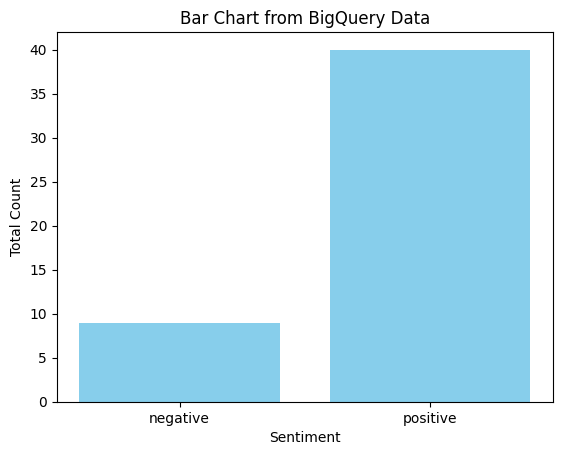

In [16]:
# Task 6.7 - Build the report.
plt.bar(sentiment, count, color='skyblue')
plt.xlabel("Sentiment")
plt.ylabel("Total Count")
plt.title("Bar Chart from BigQuery Data")
plt.show()

In [17]:
# Create an HTML table for the counts of negative and positive sentiment and color codes the results.
html_counts = f"""
<table style="border-collapse:collapse;width:25%;padding:10px;">

<tbody><tr style="background-color:#f2f2f2;">
<th style="padding:10px;text-align:left;">Negative</th>
<th style="padding:10px;text-align:left;">Positive</th>
</tr>


<tr style="padding:10px;">
<td style="padding:10px;color:red;">{count[0]}</td>
<td style="padding:10px;color:green;">{count[1]}</td>
</tr>

</tbody></table>
"""

# Display the HTML tables
display(HTML(html_counts))

Negative,Positive
9,40


In [18]:
# Conduct sentiment analysis on audio files and respond to the customer.
vertexai.init(project="qwiklabs-gcp-01-e00320b4bc7b", location="us-central1")

model = GenerativeModel(model_name="gemini-1.5-flash")

prompt = """
Please provide a transcript for the audio.
Then provide a summary for the audio.
Then identify the keywords in the transcript.
Be concise and short.
Do not make up any information that is not part of the audio and do not be verbose.
Then determine the sentiment of the audio: positive, neutral or negative.

Also, you are a customr service representative.
How would you respond to this customer review?
From the customer reviews provide actions that the location can take to improve. The response and the actions should be simple, and to the point. Do not include any extraneous characters in your response.
Answer in JSON format with five keys: transcript, summary, keywords, sentiment, response and actions. Transcript should be a string, summary should be a sting, keywords should be a list, sentiment should be a string, customer response should be a string and actions should be string.
"""

bucket_name = "qwiklabs-gcp-01-e00320b4bc7b-bucket"
folder_name = 'gsp1249/audio'  # Include the trailing '/'

def list_mp3_files(bucket_name, folder_name):
   storage_client = storage.Client()
   bucket = storage_client.bucket(bucket_name)
   print('Accessing ', bucket, ' with ', storage_client)

   blobs = bucket.list_blobs(prefix=folder_name)

   mp3_files = []
   for blob in blobs:
      if blob.name.endswith('.mp3'):
            mp3_files.append(blob.name)
   return mp3_files

file_names = list_mp3_files(bucket_name, folder_name)
if file_names:
   print("MP3 files found:")
   print(file_names)
   for file_name in file_names:
      audio_file_uri = f"gs://{bucket_name}/{file_name}"
      print('Processing file at ', audio_file_uri)
      audio_file = Part.from_uri(audio_file_uri, mime_type="audio/mpeg")
      contents = [audio_file, prompt]
      response = model.generate_content(contents)
      print(response.text)
else:
   print("No MP3 files found in the specified folder.")

Accessing  <Bucket: qwiklabs-gcp-01-e00320b4bc7b-bucket>  with  <google.cloud.storage.client.Client object at 0x7e6734628550>
MP3 files found:
['gsp1249/audio/data-beans_review_1395.mp3', 'gsp1249/audio/data-beans_review_2199.mp3', 'gsp1249/audio/data-beans_review_2763.mp3', 'gsp1249/audio/data-beans_review_2884.mp3', 'gsp1249/audio/data-beans_review_7061.mp3']
Processing file at  gs://qwiklabs-gcp-01-e00320b4bc7b-bucket/gsp1249/audio/data-beans_review_1395.mp3
```json
{
 "transcript": "Great place. The coffee is always good and the service is quick and friendly.",
 "summary": "The customer had a positive experience, praising the coffee and the friendly and quick service.",
 "keywords": ["great", "coffee", "good", "service", "quick", "friendly"],
 "sentiment": "positive",
 "response": "Thank you for the kind words! We're glad you enjoyed your coffee and our friendly service. We strive to make every visit a great one.",
 "actions": "Continue providing high-quality coffee and excellent c

In [19]:
# Generate the transcript for the negative review audio file, create the JSON object, and associated variables

audio_file_uri = f"gs://{bucket_name}/{folder_name}/data-beans_review_7061.mp3"
print(audio_file_uri)

audio_file = Part.from_uri(audio_file_uri, mime_type="audio/mpeg")

contents = [audio_file, prompt]

response = model.generate_content(contents)
print('Generating Transcript...')
#print(response.text)

results = response.text
# print("your results are", results, type(results))
print('Transcript created...')

print('Transcript ready for analysis...')

json_data = results.replace('```json', '')
json_data = json_data.replace('```', '')
jason_data = '"""' + results + '"""'

# print(json_data, type(json_data))

data = json.loads(json_data)

# print(data)

transcript = data["transcript"]
summary = data["summary"]
sentiment = data["sentiment"]
keywords = data["keywords"]
response = data["response"]
actions = data["actions"]

gs://qwiklabs-gcp-01-e00320b4bc7b-bucket/gsp1249/audio/data-beans_review_7061.mp3
Generating Transcript...
Transcript created...
Transcript ready for analysis...


In [21]:
# Create an HTML table (including the image) from the selected values.

html_string = f"""
<table style="border-collapse:collapse;width:100%;padding:10px;">
<tbody><tr style="background-color:#f2f2f2;">
<th style="padding:10px;width:50%;text-align:left;">customer_id: 7061 - @coffee_lover789</th>
<th style="padding:10px;width:50%;text-align:left;">&nbsp;</th>
</tr>
</tbody></table>
<table>

<tbody><tr style="padding:10px;">
<td style="padding:10px;">{transcript}</td>
<td style="padding:10px;color:red;">{sentiment} feedback</td>
</tr>
<tr>
</tr>
<tr style="padding:10px;">
<td style="padding:10px;">&nbsp;</td>
<td style="padding:10px;">
<table>

<tbody><tr><td>{keywords[0]}</td></tr>
<tr><td>{keywords[1]}</td></tr>
<tr><td>{keywords[2]}</td></tr>
<tr><td>{keywords[3]}</td></tr>

</tbody></table>
</td>
</tr>
<tr style="padding:10px;">
<td style="padding:10px;">
<strong>Customer summary:</strong>{summary}</td>
</tr>
<tr style="padding:10px;">
<td style="padding:10px;">
<strong>Recommended actions:</strong>{actions}</td>
</tr>
<tr style="padding:10px;">
<td style="padding:10px;background-color:#EAE0CF;">
<strong>Suggested Response:</strong>{response}</td>
</tr>

</tbody></table>

"""
print('The table has been created.')

The table has been created.


In [22]:
# Download the audio file from Google Cloud Storage and load into the player
storage_client = storage.Client()
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(f"{folder_name}/data-beans_review_7061.mp3")
audio_bytes = io.BytesIO(blob.download_as_bytes())

# Assuming a sample rate of 44100 Hz (common for MP3 files)
sample_rate = 44100

print('The audio file is loaded in the player.')

The audio file is loaded in the player.


In [23]:
# Task 7.5 - Build the mockup as output to the cell.
print('Analysis complete. Review the results below.')
display(HTML(html_string))
display(Audio(audio_bytes.read(), rate=sample_rate, autoplay=True))

Analysis complete. Review the results below.
